In [1]:
#Libraries
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as optimize
import scipy.integrate as integrate
import scipy.constants as constants
import scipy.signal as signal

Ce cahier suit les lignes directrices des chapitres 8 et 10 du Livre Électrochimie physique et analytique écrit par  Hubert H. Girault aux presses polytechniques et universitaires romandes (ISBN 978-2-88074-673-5)

Ce cahier a été écrit pour les étudiants de la formation Sciences de la matière de l'ENS de Lyon.

Auteur : Martin Vérot

Licence : CC BY-NC-SA Licence

In [2]:
DR = 6.04e-10
DO = 6.04e-10
n = 1
E0 = 0.77
F = constants.physical_constants['Faraday constant'][0]
R = constants.R
C_red = 0.05
C = 0.05
T =298
Ef = 0.97
Ei = 0.57
nu = 100e-3 #(sweep rate)
A = 1
#temps
tmax = 8

Alors que pour une expérience de chronoampérométrie on applique un fonction d'heaviside, pour une expérience de voltampérométrie cyclique, on balaye en potentiel avec un profil triangulaire. Ce triangle est généralement caractérisé par trois valeurs : 
* le potentiel de départ $E_i$
* le potentiel de retour $E_f$
* la vitesse de balayage $\nu$

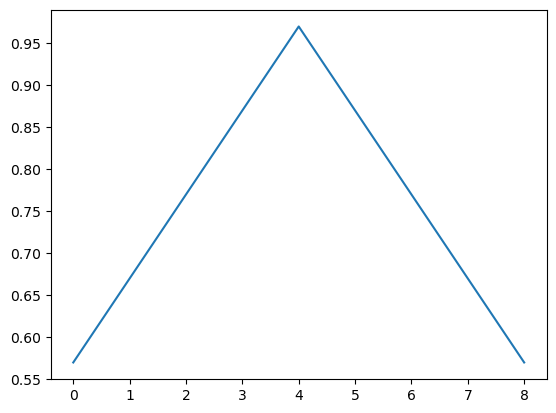

In [3]:
def triangle(ts,nu,Ei,Ef):
    """
    -ts : temps auxquels calculer le potentiel
    -nu : vitesse de balayage en V/s
    -Ei : potentiel initial
    -Ef : potentiel final
    """
    moyenne = (Ei+Ef)/2
    amplitude = (Ei-Ef)/2
    frequence = np.abs((nu)/(2*(Ef-Ei)))
    #On change la phase pour que le potentiel croisse ou décroisse initialement
    #compensation entre le signe de l'amplitude et la phase quand on a Ei < Ef ou l'inverse
    phase =  np.pi
    return moyenne + amplitude * signal.sawtooth(2*np.pi*frequence * ts + phase, 0.5)


Nmax = 1001
ts,dt = np.linspace(0,tmax,Nmax,retstep=True)
#potentiels correspondants
Es = triangle(ts,nu,Ei,Ef)

plt.plot(ts,Es)
plt.show()

Comme d'habitude, on se place de manière à être controlé par la diffusion, donc on cherche à résoudre la seconde équation de Fick pour l'oxydant et le réducteur :
$$ \dfrac{\partial c_R}{\partial t} = D_R \dfrac{\partial^2 c_R}{\partial x^2} $$
$$ \dfrac{\partial c_O}{\partial t} = D_O \dfrac{\partial^2 c_O}{\partial x^2} $$

Si on part uniquement d'une solution contenant le réducteur, les conditions aux limites sont les suivantes :
* $c_R (x, t=0) = c_R$
* $C_O (x, t=0) = 0$

De plus :
* $\lim_{x\to\infty} c_R(x,t) = c_R$
* $\lim_{x\to\infty} c_O(x,t) = 0$

Une des conditions aux limites supplémentaire est donnée par la conservation de la quantité de matière. Cela impose que les flux diffusifs à l'électrode des deux espèces (oxydant et réducteur) soient égales :

$$D_O \left.\dfrac{\partial {c_O}}{\partial x}\right|_{x=0}+D_R \left.\dfrac{\partial {c_R}}{\partial x}\right|_{x=0} = 0$$

De plus, le couple étant rapide, le rapport de concentration à l'électrode est fixé par son potentiel, qui suit la loi de Nernst :
$$E(t)=E^\circ + \frac{RT}{nF}\ln\left(\frac{ c_O(x=0,t)}{c_R(x=0,t)}\right)$$
On peut ré-écrire cette relation sous la forme :
$$\dfrac{c_R(0,t)}{c_O(0,t)} = \exp\left( - \frac{nF}{RT}(E(t)-E^\circ)\right) = \theta S(t)$$
avec :
$$\theta =\exp\left( - (E_i-E^\circ)\frac{nF}{RT}\right) $$
$$ S(t) = \exp(-\sigma t) \quad\quad \sigma = \frac{nF}{RT}\nu$$

In [4]:
theta = np.exp(-(Ei-E0)* n *F / (R*T))
sigma = n*F/(R*T) * nu
nFRT = n*F/(R*T)
def S(t,sigma):
    return np.exp(-sigma * t)

def thetaS(ts,nu,Ei,Ef,E0,nFRT):
    Es = triangle(ts,nu,Ei,Ef)
    return np.exp(-nFRT*(Es-E0))



En faisant la transformée de Laplace de l'équation de Fick, on a :

\begin{align}
s \overline{c_R}(x,s) -c_R(x,0) ={}& D_R \dfrac{\partial^2 \overline{c_R}}{\partial x^2}\\
\dfrac{\partial^2 \overline{c_R}}{\partial x^2}- \dfrac{s}{D_R}\overline{c_R}(x,s) = - \dfrac{c_R}{D_R}
\end{align}

La solution générale de cette équation est somme d'une solution particulière et d'une solution de l'équation homogène (dont on enlevé le terme exponentiel croissant avec $x$ qui tendrait vers l'infini en $x\to \infty$):
$$\overline{c_R}(x,s) = \dfrac{c_R}{s} + \overline{A_R}(s) \exp\left(-\sqrt{\frac{s}{D_R}}x\right)$$

Pour calculer le courant, il faut maintenant calculer le flux diffusif $J_R(x,t)$ en $x=0$ : 
$$I(t) = -nFAJ_R(x=0,t) = nFA D_R \left.\dfrac{\partial {c_R}}{\partial x}\right|_{x=0}$$
On peut calculer cette dérivée dans l'espace réciproque avant de faire la transformée inverse :
$$\overline{I}(s)=nFA D_R \left.\dfrac{\partial \overline{c_R}}{\partial x}\right|_{x=0} = nFA D_R  \left[-\overline{A_R}(s)\sqrt{\dfrac{s}{D_R}}\right]$$

Ce qui revient à écrire que :
$$\overline{A_R}(s) = -\dfrac{\overline{I}(s)}{nFA D_R}\sqrt{\dfrac{D_R}{s}} = -\dfrac{1}{nFA \sqrt{D_R}}\overline{I}(s)\times \frac{1}{\sqrt{s}}$$


Il faut maintenant faire la transformée inverse de Laplace pour obtenir l'expression de la concentration. Le deuxième terme peut s'écrire comme un produit de fonction de la forme $\overline{I}(s) \times \frac{1}{\sqrt{s}}$. On peut alors utiliser les propriétés de la transformée de Laplace :

$$L^{-1} \left\{\overline{F}(s)\overline{G}(s)\right\} = \int_0^t F(\tau)G(t-\tau) \mathrm{d}\tau$$

De plus, on peut montrer que la transformée inverse de $1/\sqrt{s}$ est la fonction $1/\sqrt{\pi t}$.

On a donc :
$$c_R (0,t) = c_R - \dfrac{1}{nFA \sqrt{\pi D_R}} \int _0 ^t I(\tau)\dfrac{1}{\sqrt{t-\tau}} \mathrm{d}\tau $$

Si on écrit $f(\tau) = \dfrac{1}{nFA}I(\tau)$ :
$$c_R (0,t) = c_R - \dfrac{1}{\sqrt{\pi D_R}} \underbrace{\int _0 ^t f(\tau)\dfrac{1}{\sqrt{t-\tau}} \mathrm{d}\tau }_{=\hat{I}(t)}$$
L'intégrale $\hat{I}(t)$ est appelée courant convolué.

De manière analogue, on a:
$$c_O (0,t) = c_O + \dfrac{1}{\sqrt{\pi D_O}} \int _0 ^t f(\tau)\dfrac{1}{\sqrt{t-\tau}} \mathrm{d}\tau \approx \dfrac{1}{\sqrt{\pi D_O}} \hat{I}(t) $$

On a donc :
$$\dfrac{c_R(0,t)}{c_O(0,t)} =  \theta S(t) = \dfrac{c_R - \frac{\hat{I}(t)}{\sqrt{\pi D_R} } }{\frac{\hat{I}(t)}{\sqrt{\pi D_O} }} $$

On peut en extraire l'expression de $\hat{I}(t)$ :
$$\hat{I}(t) = \dfrac{c_R\sqrt{\pi D_R}}{1+\xi\theta S(t)} \qquad\qquad \xi = \sqrt{\dfrac{D_R}{D_O}}$$

In [5]:
xi = np.sqrt(DR/DO)
print(xi)

1.0


Il est maintenant possible de faire le changement de variable $z=\sigma \tau\qquad \mathrm{d}\tau = \mathrm{d}z/\sigma$ avec $f(\tau) = g(z)$. On a alors :
$$\hat{I}(t)  =\int_0 ^{\sigma t} \dfrac{g(z)}{c_R\sqrt{\pi D_R}} \dfrac{1}{\sqrt{t-\frac{z}{\sigma}}}\dfrac{\mathrm{d}z}{\sigma} = c_R \sqrt{\pi D_R \sigma} \int_0 ^{\sigma t} \chi(z) \dfrac{\mathrm{d}z}{\sqrt{\sigma t-z}}$$
Où $\chi(z)$ est une fonction sans dimension :
$$ \chi(z) = \dfrac{I(\sigma t)}{c_R \sqrt{\pi D_R \sigma}}$$

On peut alors se ramener à une équation adimensionnée :
$$\int_0 ^{\sigma t} \chi(z) \dfrac{\mathrm{d}z}{\sqrt{\sigma t-z}} = \underbrace{\dfrac{1}{1+\xi\theta S(\sigma t)}}_{\mathtt{fraction}}$$


In [6]:
def fraction(ts,nu,Ei,Ef,E0,nFRT,xi):
    return 1./(1.+xi*thetaS(ts,nu,Ei,Ef,E0,nFRT))

L'intégrale complète est techniquement difficile à évaluer à cause de la discontinuité en $z=\sigma t$ liée au terme en $\dfrac{1}{\sqrt{\sigma t -z}}$. Il faut donc passer par une résolution numérique. 

Pour cela, on découpe l'intervalle $[0,\sigma t]$ en $N$ intervalles de longueur $\delta$. Cela permet également de poser le changement de variable $z=\alpha \delta$ avec $\alpha$ qui va varier continuement de 0 à $N$. En pratique, plutôt que de couper chaque intervalle $[0,\sigma t]$, on va couper l'intervalle complet de temps $[0,\sigma t_\mathrm{max}]$ en $N$ intervalles ($t_\mathrm{max}$ étant la durée totale de l'expérience).

![intervalles.svg](intervalles.svg)

On a alors :
$$\int_0 ^{\sigma t} \chi(z) \dfrac{\mathrm{d}z}{\sqrt{\sigma t-z}} = \int_0 ^{j \delta} \chi(\alpha \delta) \dfrac{\mathrm{d} (\alpha \delta)}{\sqrt{\delta}\sqrt{j-\alpha}}$$

On peut maintenant faire une intégration par partie :
$$u =\chi(\alpha \delta) \qquad v' =  \dfrac{1}{\sqrt{\delta}\sqrt{j-\alpha}}$$
$$u' =\chi'(\alpha \delta) \qquad v = - 2\sqrt{\delta}\sqrt{j-\alpha}$$


$$\int_0 ^{\sigma t} \chi(z) \dfrac{\mathrm{d}z}{\sqrt{\sigma t-z}}  = \underbrace{\left[-\chi(\alpha \delta)2\sqrt{\delta}\sqrt{j-\alpha}\right]_0^{j\delta}}_{= 2\chi(0)\sqrt{j\delta}}+\int_0 ^{j \delta}\chi'(\alpha \delta)2\sqrt{\delta}\sqrt{j-\alpha}\, \mathrm{d} (\alpha \delta) $$


En remplaçant la dérivée $ \chi'(\alpha \delta) $ par son approximation : $$ \chi'(\alpha \delta) \approx \dfrac{\chi((\alpha+1) \delta)-\chi(\alpha \delta)}{\delta} $$

Puis en approximant l'intégrale de droite par une somme de Riemann :
$$\int_0^{j\delta} f(\alpha\delta)d(\alpha\delta) = \sum_{i=0}^{j-1} \delta \times f(i\delta)$$


On a alors : 
$$\int_0 ^{j \delta}\chi'(\alpha \delta)2\sqrt{\delta}\sqrt{j-\alpha}\, \mathrm{d} (\alpha \delta)  \approx 2\sum_{i=0}^{j-1} \int_{i\delta}^{(i+1)\delta}\sqrt{\delta}\sqrt{j-\alpha}\underbrace{\dfrac{\chi((\alpha+1) \delta)-\chi(\alpha \delta)}{\delta}}_{\chi'(\alpha \delta)} \, \mathrm{d} (\alpha \delta)  \approx 2\sum_{i=0}^{j-1} \sqrt{\delta}\sqrt{j-i}\underbrace{\dfrac{\chi((i+1) \delta)-\chi(i \delta)}{\delta}}_{\chi'(i \delta)}\delta$$

Donc :
\begin{align} \int_0 ^{\sigma t} \chi(z) \dfrac{\mathrm{d}z}{\sqrt{\sigma t-z}}={}& 2\chi(0)\sqrt{j\delta}+2\sqrt{\delta}\sum_{i=0}^{j-1} \sqrt{j-i}\left[\chi((i+1) \delta)-\chi(i \delta)\right]\\
={}&2\chi(\delta)\sqrt{j\delta}+2\sqrt{\delta}\sum_{i=1}^{j-1} \sqrt{j-i}\left[\chi((i+1) \delta)-\chi(i \delta)\right]\\
={}& \dfrac{1}{1+\xi\theta S(\sigma t)} = \dfrac{1}{1+\xi\theta S(j \delta)}
\end{align}

On cherche donc à résoudre l'équation :
$$2\sqrt{\delta}\left[\chi(\delta)\sqrt{j}+\sum_{i=1}^{j-1} \sqrt{j-i}\left[\chi\left(\left(i+1\right) \delta\right)-\chi\left(i \delta\right)\right]\right]=\dfrac{1}{1+\xi\theta S(j \delta )}$$
Qui peut se ré-écrire sous la forme en isolant le terme $i = j-1$ de la somme :
$$\chi(j\delta) = \underbrace{\dfrac{1}{2\sqrt{\delta}}\dfrac{1}{1+\xi\theta S(j\delta)}}_{=\mathtt{term1}} \underbrace{- \chi(\delta)\sqrt{j} \vphantom{\dfrac{1}{2\sqrt{\delta}}}}_{=\mathtt{term2}}\underbrace{-\sum_{i=1}^{j-2} \sqrt{j-i}\left[\chi((i+1) \delta)-\chi(i \delta)\right]}_{=\mathtt{term3}}\underbrace{+\chi((j-1)\delta)\vphantom{\dfrac{1}{2\sqrt{\delta}}}}_{=\mathtt{term4}}$$

# Algorithme de résolution numérique

Il est alors possible de calculer $\chi(j\delta)$ de manière itérative en faisant croître $j$ de 1 à $N$ :


* On prend $j=1$, l'équation se résume alors à :
\begin{align}
\chi(\delta) = \dfrac{1}{2\sqrt{\delta}}\dfrac{1}{1+\xi\theta S(\delta)}\qquad\text{pour $j=1$}
\end{align}
* On peut donc avoir l'expression de $\chi(\delta)$.
* On prend  $j=2$, 
$$\chi(2\delta) = \underbrace{\dfrac{1}{2\sqrt{\delta}}\dfrac{1}{1+\xi\theta S(2\delta)}\vphantom{\dfrac{1}{2\sqrt{\delta}}}}_{=\mathtt{term1}} \underbrace{-\chi(\delta)\sqrt{2}\vphantom{\dfrac{1}{2\sqrt{\delta}}}}_{=\mathtt{term2}} \underbrace{+ \chi(\delta)\vphantom{\dfrac{1}{2\sqrt{\delta}}}}_{=\mathtt{term4}} $$
l'équation est alors fonction de $\dfrac{1}{1+\xi\theta S(2\delta)}$ qui est calculable analytiquement, de $\chi(\delta)$ (connu à l'étape précédente) et de $\chi(2\delta)$. (`term3` est un terme nul ici.)
* On peut donc en déduire $\chi(2\delta)$.
* Puis on peut trouver $\chi(j\delta)$ de proche en proche en faisant tendre $j$ vers $N$ : 
\begin{align}
\chi(j\delta)-\chi((j-1)\delta) = \dfrac{1}{2\sqrt{\delta}}\dfrac{1}{1+\xi\theta S(j\delta)} - \chi(\delta)\sqrt{j}-\sum_{i=1}^{j-2} \sqrt{j-i}\left[\chi((i+1) \delta)-\chi(i \delta)\right]\\
\chi(j\delta) = \underbrace{\dfrac{1}{2\sqrt{\delta}}\dfrac{1}{1+\xi\theta S(j\delta)}}_{=\mathtt{term1}} \underbrace{- \chi(\delta)\sqrt{j} \vphantom{\dfrac{1}{2\sqrt{\delta}}}}_{=\mathtt{term2}}\underbrace{-\sum_{i=1}^{j-2} \sqrt{j-i}\left[\chi((i+1) \delta)-\chi(i \delta)\right]}_{=\mathtt{term3}}\underbrace{+\chi((j-1)\delta)\vphantom{\dfrac{1}{2\sqrt{\delta}}}}_{=\mathtt{term4}}
\end{align}
où :
    * `term1` est calculable car il ne dépend que de $\delta$, $\xi = \sqrt{\dfrac{D_R}{D_O}}$ et de la fonction $\theta S(j\delta)$ qui est calculable analytiquement,
    * `term2` est aussi calculable vu que l'on a accès à $\chi(\delta)$
    * `term3` est calculable car on a accès à toutes les valeurs de $\chi(i\delta)$ pour $i < j$
    * `term4` a été calculé à l'étape précédente


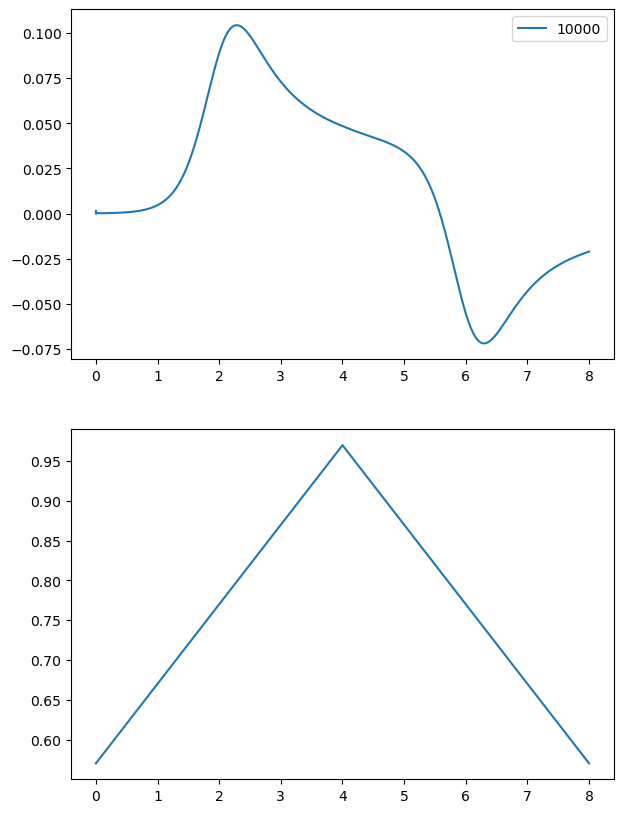

In [30]:
fig,axes = plt.subplots(1,2,figsize=(7,10))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
#N correspond au nombre d'intervalles utilisés pour découper l'intervalle 0, tmax
N=5000
#Découpage des intervalles
js = np.arange(1,N+1)
#Multiplication par 1. pour avoir un tableau de nombres flottants
chi = np.zeros_like(js)*1.

#Calcul des intervalles pour découper sigma tmax en N intervalles
sigmastep,delta = np.linspace(0,sigma*tmax,N,retstep=True)
#intervalles de temps correspondants aux intervalles sigmastep
tstep,deltat = sigmastep/sigma,delta/sigma

#Calcul du terme chi(delta)
chi[0] = 1./(2.*np.sqrt(delta))*fraction(deltat,nu,Ei,Ef,E0,nFRT,xi)    
for j in js :
    Nbis = np.arange(1,j-1)
    term1 = 1/(2*np.sqrt(delta))*fraction(deltat*j,nu,Ei,Ef,E0,nFRT,xi)
    term2 = -chi[0]*np.sqrt(j)
    term3 = 0
    if j>2:
        inside_sum = np.sqrt(j-Nbis)*(chi[1:j-1]-chi[:j-2])
        term3 = -np.sum(inside_sum)   
    term4 = chi[j-2]  
    chi[j-1] = term1+term2+term3+term4 
ax1.plot(tstep,chi*n*F*A*C_red*np.sqrt(np.pi * DR * sigma),label='{}'.format(N))


Es = triangle(tstep,nu,Ei,Ef)
ax2.plot(tstep,Es)
ax1.legend()
plt.show()

Que l'on peut remettre sous sa forme plus classique de courbe $I=f(E)$.

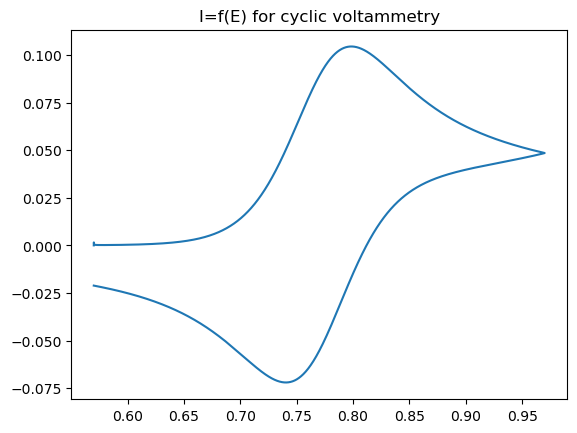

In [31]:
plt.plot(Es,chi*n*F*A*C_red*np.sqrt(np.pi * DR * sigma))
plt.title('I=f(E) for cyclic voltammetry')
plt.show()

Un des avantages de la méthode de calcul utilisée est que la fonction $\chi$ est indépendante de la valeur de $\sigma$ et donc de la vitesse de balayage. Une fois cette fonction calculée, il n'est en toute rigueur pas nécessaire de la recalculer à chaque fois.

De plus, cette fonction présente un maximum pour lequel $\sqrt{\pi}\chi = 0,4463$ pour une valeur de $E(t)-E^\circ$ qui vaut 28,5 mV.

maximum de \sqrt{\pi}\chi
0.4462947213394821
valeur de E-E^\circ qui maximise \chi en mV
0.02842284228422831


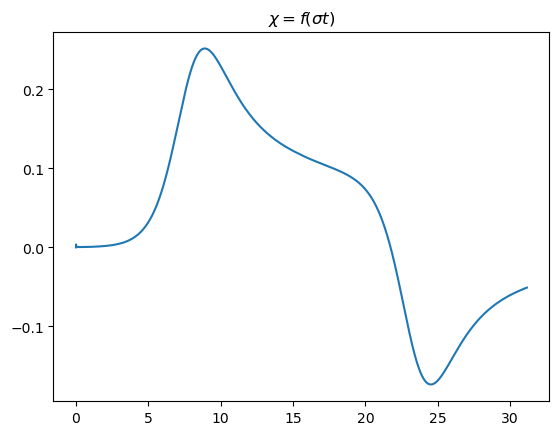

In [36]:
plt.plot(sigmastep,chi)
plt.title('$\chi = f(\sigma t) $')
print('maximum de \sqrt{\pi}\chi')
print(np.max(chi)*np.sqrt(np.pi))
index = np.argmax(chi)
print('valeur de E-E^\circ qui maximise \chi en mV' )
print(Es[index]-E0)

# Généralisation 

Une fois la méthode générale comprise, il est possible de faire varier les différents paramètres de l'expérience :
* vitesse de balayage $\nu$
* valeur de $E_i$ et $E_f$
* $k$ : le nombre de cycles de voltamétrie
* voir la convergence de l'intégrale avec $N$

In [14]:
import ipywidgets as widgets
from IPython.display import display
%matplotlib inline

def plot_curve(nu,Ei,Ef,k,N):
    fig = plt.figure(figsize=(15, 10))
    gs = fig.add_gridspec(2, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[:, 1])
    #N correspond au nombre d'intervalles utilisés pour découper l'intervalle 0, tmax
    sigma = nFRT * nu

    tmax = k * 2 * np.abs(Ef-Ei)/nu
    #Découpage des intervalles
    js = np.arange(1,N+1)
    #Multiplication par 1. pour avoir un tableau de nombres flottants
    chi = np.zeros_like(js)*1.

    #Calcul des intervalles pour découper sigma tmax en N intervalles
    sigmastep,delta = np.linspace(0,sigma*tmax,N,retstep=True)
    #intervalles de temps correspondants aux intervalles sigmastep
    tstep,deltat = sigmastep/sigma,delta/sigma


    #Calcul du terme chi(delta)
    chi[0] = 1./(2.*np.sqrt(delta))*fraction(deltat,nu,Ei,Ef,E0,nFRT,xi)    
    for j in js :
        Nbis = np.arange(1,j-1)
        term1 = 1/(2*np.sqrt(delta))*fraction(deltat*j,nu,Ei,Ef,E0,nFRT,xi)
        term2 = -chi[0]*np.sqrt(j)
        term3 = 0
        if j>2:
            inside_sum = np.sqrt(j-Nbis)*(chi[1:j-1]-chi[:j-2])
            term3 = -np.sum(inside_sum)   
        term4 = chi[j-2]  
        chi[j-1] = term1+term2+term3+term4 
    ax1.plot(tstep,chi*n*F*A*C_red*np.sqrt(np.pi * DR * sigma),label='{}'.format(N))


    Es = triangle(tstep,nu,Ei,Ef)
    ax2.plot(tstep,Es)
    ax1.legend()

    ax3.plot(Es,chi*n*F*A*C_red*np.sqrt(np.pi * DR * sigma))
    ax3.set_title('I=f(E) for cyclic voltammetry')


    plt.show()   
    
interactive_plot = widgets.interactive(plot_curve,
                                       nu=widgets.FloatSlider(value = 100e-3, min =10e-3,max=2,step=1e-3,description = 'vitesse de balayage $\\nu$',style=dict(description_width='initial'), continuous_update=False),
                                       Ei=widgets.FloatSlider(value = 0.57, min =0,max=0.67,step=1e-2,description = 'Potentiel initial $E_i$',style=dict(description_width='initial'), continuous_update=False),
                                       Ef=widgets.FloatSlider(value = 0.97, min =0.87,max=2,step=1e-2,description = 'Potentiel final $E_f$',style=dict(description_width='initial'), continuous_update=False),
                                       k=widgets.IntSlider(value = 1, min =1,max=10,description = 'Nombre de cycle $k$',style=dict(description_width='initial'), continuous_update=False),
                                       N=widgets.IntSlider(value = 500, min =10,max=10001,step=10,description = 'Découpage de l\'intervalle $N$',style=dict(description_width='initial'), continuous_update=False),
                                      )#nu,Ei,Ef,k,N


output = interactive_plot.children[-1]
output.layout.height = '800px'
interactive_plot
    

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='vitesse de balayage $\\nu$'…